In [ ]:
!apt install -y libsndfile1 ffmpeg
!pip install librosa
!pip install musdb
!pip install museval
!pip install -q scikit_posthocs
!pip install ffprobe
!pip install kapre==0.3.4
!pip install tqdm
from google.colab import drive
drive.mount('/gdrive')
path = "/gdrive/My Drive/musdb_trim/"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
     |████████████████████████████████| 512kB 14.1MB/s 
     |████████████████████████████████| 133kB 12.6MB/s 
  Created wheel for ffprobe: filename=ffprobe-0.5-cp36-none-any.whl size=3431 sha256=db12c7d9673f16e4ce758b0351bdb25c9bb12fd896b49504b6637c9f417c7fc1
  Stored in directory: /root/.cache/pip/wheels/a0/fe/3b/8af08ae1cdfc27e226779e2cb1a7c8a2ba4954c05c562cdc77
Successfully built ffprobe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 184kB 11.0MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Created wheel for kapre: filename=kapre-0.3.4-cp36-none-any.whl size=20608 sha

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import kapre
from kapre.composed import get_melspectrogram_layer, get_perfectly_reconstructing_stft_istft
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import scipy.stats
import stempeg
import musdb
import os
from scipy.io import wavfile
from tqdm import tqdm

In [ ]:
path = "/gdrive/My Drive/musdb_trim/"

trainpath = path +"train/"
testpath = path +"test/"

# Load MUSDB18 Data from drive
data = musdb.DB(is_wav=True, root=path)
print(type(data))
print(len(data))

<class 'musdb.DB'>
144


In [ ]:
# Perform train - validation - test split

musdbtrain= data.load_mus_tracks(subsets="train", split = "train")
musdbval = data.load_mus_tracks(subsets="train", split = "valid")
musdbtest = data.load_mus_tracks(subsets="test")

print(len(musdbtrain))
print(len(musdbval))
print(len(musdbtest))


80
14
50


In [ ]:
# Play an example track and all it's stems

testtrack = musdbtrain[0]

x = testtrack.targets['vocals']

print("Sampling rate:",testtrack.rate)

print("Mixture")
display(Audio(testtrack.audio.T,rate = testtrack.rate))

print("Vocals")
display(Audio(testtrack.targets['vocals'].audio.T,rate = testtrack.targets['vocals'].rate))

print("Bass")
display(Audio(testtrack.targets['bass'].audio.T,rate = testtrack.targets['bass'].rate))

print("Drums")
display(Audio(testtrack.targets['drums'].audio.T,rate = testtrack.targets['drums'].rate))

print("Accompaniment")
display(Audio(testtrack.targets['accompaniment'].audio.T,rate = testtrack.targets['accompaniment'].rate))

print("Others")
display(Audio(testtrack.targets['other'].audio.T,rate = testtrack.targets['other'].rate))

In [ ]:
# Function to display spectrogram. Uses librosa to convert signal to mono and then runs the stft function along with pyplot to generate the spectrogram
def displaySpec(track, stemname):
  if stemname == 'mix':
    X = librosa.stft(librosa.to_mono(track.audio.T))
    print("Mixture Spectrogram")
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max), y_axis='log', x_axis='time')
    plt.show()
  else:
    try:
      X = librosa.stft(librosa.to_mono(track.targets[stemname].audio.T))
      print("Spectrogram:", stemname)
      librosa.display.specshow(librosa.amplitude_to_db(np.abs(X), ref=np.max), y_axis='log', x_axis='time')
      plt.show()
    except:
      print("Invalid STEM name")

# Function to display signal as a wave.
def displayWav(track, stemname):
  if stemname == 'mix':
    y = librosa.to_mono(track.audio.T)
  else:
    try:
      y = librosa.to_mono(track.targets[stemname].audio.T)
    except:
      print("Invalid STEM name")
  plt.figure()
  plt.title("Signal Wave: "+stemname)
  plt.plot(y)
  plt.show()


Mixture Spectrogram


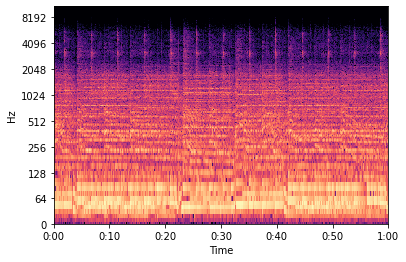

Spectrogram: vocals


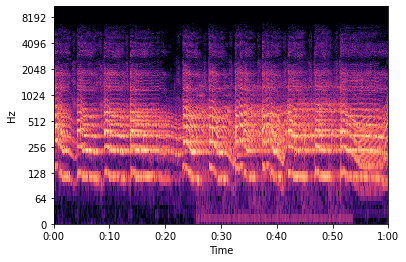

Spectrogram: drums


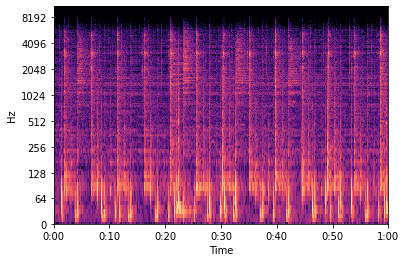

Spectrogram: bass


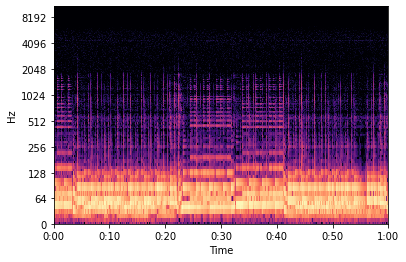

Spectrogram: other


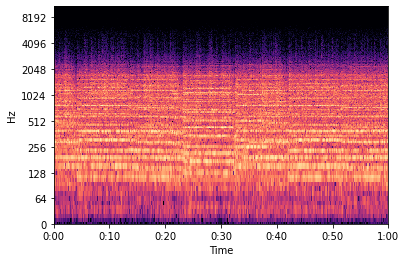

Spectrogram: accompaniment


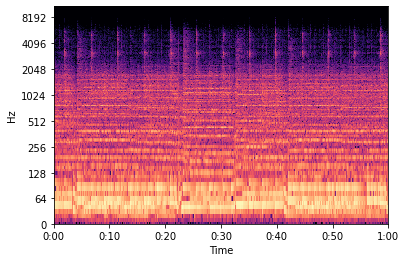

Spectrogram: linear_mixture


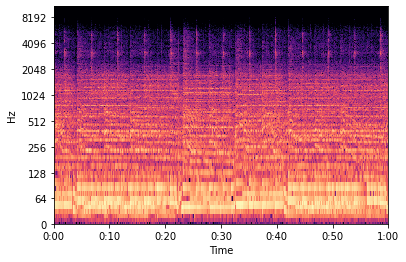

In [ ]:
# Run displaySpec and displayWav for a sample track
stemnames = list(testtrack.targets.keys())

displaySpec(testtrack, 'mix')

for name in stemnames:
  displaySpec(testtrack, name)

In [ ]:

# Q = librosa.resample(testtrack.audio.T, testtrack.rate, 22100)
# Z = librosa.to_mono(testtrack.audio.T)
# Z = Z.reshape((1,len(Z)))

# # Svoc = np.abs(librosa.stft(librosa.to_mono(testtrack.targets['vocals'].audio.T)))
# # Slm = np.abs(librosa.stft(librosa.to_mono(testtrack.targets['linear_mixture'].audio.T)))
# # eps = np.finfo(np.float).eps

# # Mvoc = np.divide(Svoc,(eps+Slm)) 

# # vocalspec = np.multiply(Z,Mvoc)

# # vocalextract = librosa.istft(vocalspec)

# # Audio(vocalextract, rate=testtrack.rate)

# print(Z.shape)
# print(Q.shape)
# print(testtrack.audio.T.shape)

# # display(Audio(Z, rate = testtrack.rate))
# # display(Audio(testtrack.audio.T, rate = testtrack.rate))
# # type(testtrack.targets['vocals'])

In [ ]:
SAMPLING_RATE = 22100

# Define data generator class

class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataarray, stemname, sr = SAMPLING_RATE, dur = 30, batch_size = 8, n_channels = 1, shuffle = False):

    self.dataarray = dataarray
    self.stemname = stemname
    self.sr = sr
    self.dur = dur
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.n_channels = n_channels
    self.c = 1


  def __len__(self):

    # Return number of batches
    return int(np.floor(len(self.dataarray)/self.batch_size))

  def __getitem__(self, index):

    # Create batches using index and 
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    trackbatch = [self.dataarray[k] for k in indexes]
    X , Y = self.__processData(trackbatch)
    return X,Y

  def on_epoch_end(self):

    # Shuffle indexes if true to ensure random ordering after each epoch
    self.indexes = np.arange(len(self.mixlist))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __processData(self, databatch):

    print("Processing batch ", self.c)
    self.c = self.c + 1

    # Batches are of shape (batch size, number of channels, sampling rate * duration)
    X = np.empty((self.batch_size, self.n_channels, int(self.sr*self.dur)))
    Y = np.empty((self.batch_size, self.n_channels, int(self.sr*self.dur)))

    name = self.stemname

    for i, track in tqdm(enumerate(databatch)):

      # Downsample audio mix. Convert to mono if required. Store in X
      s = librosa.resample(track.audio.T, track.rate, target_sr = self.sr)
      if self.n_channels == 1:
        s = librosa.to_mono(s)
        s = s.reshape(1, len(s))   
      X[i,] = s

      # Downsample individual stem. Convert to mono if required. Store in Y
      s = librosa.resample(track.targets[name].audio.T, track.targets[name].rate,target_sr = self.sr)
      if self.n_channels == 1:
        s = librosa.to_mono(s)
        s = s.reshape(1, len(s))
      Y[i,] = s 

    return X,Y

In [ ]:
# Initialize train and validation data generators 

train_gen = DataGenerator(musdbtrain, 'vocals', shuffle=True)
val_gen = DataGenerator(musdbval, 'vocals', shuffle=True)

In [ ]:
# Define Model
def createModel(SR = 22100, DT = 30.0):
  model = Sequential()
  in_shape = (1,int(SR*DT))
  ft, ift = get_perfectly_reconstructing_stft_istft(stft_input_shape= in_shape, waveform_data_format='channels_first', win_length = 2048, hop_length = 1024)
  model.add(ft)
  model.add(ift)
  # model.compile()
  return model

model = createModel()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft (STFT)                  (None, 649, 1025, 1)      0         
_________________________________________________________________
istft (InverseSTFT)          (None, 1, None)           0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
